<Axes: >

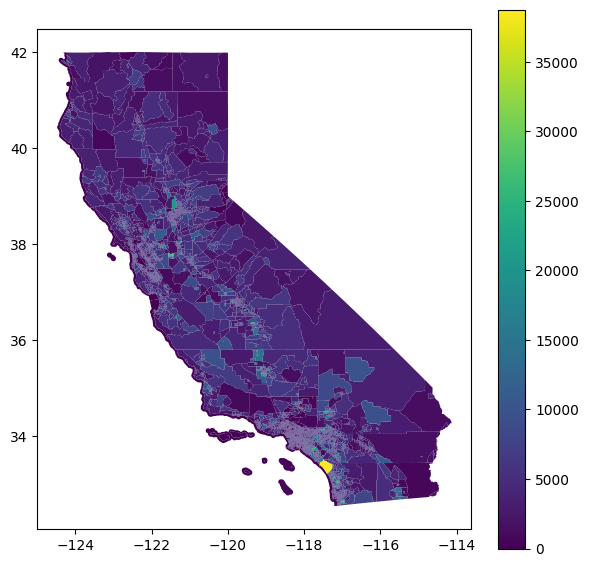

In [181]:
import pandas as pd
import geopandas as gpd
from census import Census


def get_tract_population_density(state_fips):
    c = Census("87764a72c058d93a87a9fe8ba6ef25359d9c43ba")
    
    census_data = c.acs5.state_county_tract(
        fields=['B01003_001E'],  # Population
        state_fips=state_fips,
        county_fips='*',
        tract='*',
        year=2019
    )
    
    df = pd.DataFrame(census_data)
    
    # Create GEOID
    df['GEOID'] = (df['state'].astype(str).str.zfill(2) + 
                   df['county'].astype(str).str.zfill(3) + 
                   df['tract'].astype(str).str.zfill(6))
    
    tiger_url = f"https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip"
    
    gdf = gpd.read_file(tiger_url)
    
    gdf['GEOID'] = gdf['GEOID'].astype(str)
    
    gdf = gdf.merge(df, on='GEOID', how='left')
    
    # Rename columns
    gdf = gdf.rename(columns={'B01003_001E': 'population'})
    
    gdf['area_km2'] = gdf.to_crs({'proj':'cea'}).area / 10**6
    
    # Calculate population density
    gdf['pop_density'] = gdf['population'] / gdf['area_km2']
    
    return gdf

ca_tracts = get_tract_population_density('06')

ca_tracts.plot(column='population', legend=True, figsize=(7,7))


In [ ]:
from typing import Union
from pathlib import Path
import requests
import tempfile
import os
from urllib.parse import urlparse


def load_vector(path: Union[str, Path]) -> gpd.GeoDataFrame:
    
    try:
        
        if isinstance(path, str):
            
            parsed = urlparse(path)
            if parsed.scheme in ('http', 'https'):
               
                with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(path)[1]) as tmp_file:
                    response = requests.get(path)
                    response.raise_for_status() 
                    tmp_file.write(response.content)
                    temp_path = tmp_file.name
                
                try:
                  
                    return gpd.read_file(temp_path)
                finally:
                    
                    os.unlink(temp_path)
            else:
                path = Path(path)
        
        
        if isinstance(path, Path) and not path.exists():
            raise ValueError(f"File not found: {path}")
            
        return gpd.read_file(path)
    
    except Exception as e:  
        if isinstance(e, requests.RequestException):
            raise ValueError(f"Failed to download data from URL: {str(e)}")
        else:
            raise ValueError(f"Failed to load vector data: {str(e)}")


In [67]:
water_shed = load_vector('https://gis.data.cnra.ca.gov/api/download/v1/items/45d26a15b96346f1816d8fe187f8570d/geojson?layers=0')

In [68]:
water_shed.head()

,OBJECTID,AGENCYNAME,SOURCE,AGENCYUNIQUEID,LASTMODIFIEDDATE,MODIFIEDBY,SOURCECOMMENTS,Date_Data_Applies_To,GlobalID,created_user,created_date,last_edited_user,last_edited_date,Shape_Length,Shape_Area,geometry
0,1,Del Puerto Water District,SCRO,706.0,2013-11-07 00:00:00+00:00,source,None,2013-11-07 00:00:00+00:00,{A9FB34EC-3ADA-496B-A195-ED90F7D435C2},None,NaT,None,NaT,2.941549,0.022606,"MULTIPOLYGON (((-121.0857 37.34067, -121.0881 ..."
1,2,West Stanislaus Irrigation District,SCRO,2688.0,2013-11-07 00:00:00+00:00,source,None,2013-11-07 00:00:00+00:00,{CE20083A-878E-4CEB-8D13-40FD1064A22B},None,NaT,None,NaT,0.823789,0.008944,"MULTIPOLYGON (((-121.29715 37.66738, -121.2970..."
2,3,El Solyo Water District,SCRO,828.0,2013-11-07 00:00:00+00:00,source,None,2013-11-07 00:00:00+00:00,{1EA949F8-B01A-4052-BC60-3F5B1534CB9F},None,NaT,None,NaT,0.178064,0.001668,"MULTIPOLYGON (((-121.23216 37.59463, -121.2482..."
3,4,Rock Creek Water District,SCRO,2098.0,2013-11-07 00:00:00+00:00,source,None,2013-11-07 00:00:00+00:00,{7105536C-C0ED-458C-9784-35EAF42B0C86},None,NaT,None,NaT,0.177932,0.000765,"MULTIPOLYGON (((-120.83439 37.97385, -120.8344..."
4,5,Turlock Irrigation District,SCRO,2525.0,2013-11-07 00:00:00+00:00,source,None,2013-11-07 00:00:00+00:00,{B7ABC6AD-960C-4DCE-BB67-C19E8D61465D},None,NaT,None,NaT,2.314410,0.077259,"MULTIPOLYGON (((-120.67371 37.64477, -120.6725..."


<Axes: >

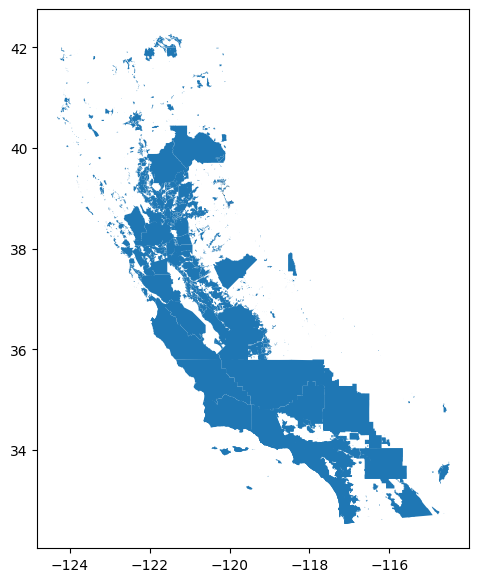

In [172]:
water_shed.plot(figsize=(7, 7))

In [169]:
def redistribute_population(source_gdf, target_gdf, pop_column):
    
    print(f"Source CRS: {source_gdf.crs}")
    print(f"Target CRS: {target_gdf.crs}")
    
    # Ensure both dataframes have the same CRS
    if source_gdf.crs != target_gdf.crs:
        print("CRS mismatch detected. Transforming source to match target CRS...")
        source_gdf = source_gdf.to_crs(target_gdf.crs)
    
    if source_gdf.crs != target_gdf.crs:
        raise ValueError("CRS mismatch even after transformation!")
    
    source_gdf = source_gdf.reset_index(drop=True)
    target_gdf = target_gdf.reset_index(drop=True)
    
    target_gdf['target_id'] = target_gdf.index
    
    intersection = gpd.overlay(source_gdf, target_gdf, how='intersection')
    
    intersection['intersection_area'] = intersection.geometry.area
    intersection['source_area'] = intersection.geometry.to_crs(intersection.crs).area
    
    intersection['weight'] = intersection['intersection_area'] / intersection['source_area']
    
    intersection['new_population'] = intersection[pop_column] * intersection['weight']
    

    target_columns = ['target_id']  
    
    result = intersection.dissolve(
        by=target_columns,
        aggfunc={'new_population': 'sum'},
        as_index=False
    )
    
    original_pop = source_gdf[pop_column].sum()
    new_pop = result['new_population'].sum()
    print(f"\nValidation:")
    print(f"Original total population: {original_pop}")
    print(f"New total population: {new_pop}")
    print(f"Difference: {abs(original_pop - new_pop)}")
    
    return result

try:
    redistributed_pop = redistribute_population(ca_tracts, water_shed, 'population')
except ValueError as e:
    print(f"Error: {e}")


Source CRS: EPSG:4269
Target CRS: EPSG:4326
CRS mismatch detected. Transforming source to match target CRS...


/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_88936/4254152506.py:19: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection = gpd.overlay(source_gdf, target_gdf, how='intersection')
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_88936/4254152506.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['intersection_area'] = intersection.geometry.area
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_88936/4254152506.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersection['source_area'] = intersection.geometry.to_crs(intersection.crs)


Validation:
Original total population: 39283497.0
New total population: 166991428.0
Difference: 127707931.0


In [170]:
redistributed_pop.head() 

,target_id,geometry,new_population
0,0,"MULTIPOLYGON (((-121.12092 37.44982, -121.1125...",40524.0
1,1,"MULTIPOLYGON (((-121.14418 37.4906, -121.14418...",30034.0
2,2,"POLYGON ((-121.24821 37.5947, -121.25156 37.59...",6076.0
3,3,"POLYGON ((-120.83443 37.95936, -120.81598 37.9...",5330.0
4,4,"MULTIPOLYGON (((-121.02753 37.4483, -121.02874...",247210.0


Text(0.5, 1.0, 'Redistributed Population in Watershed')

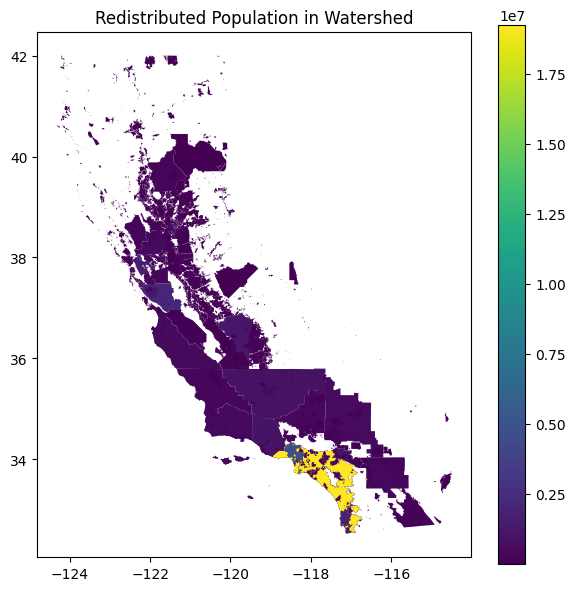

In [173]:
redistributed_pop.plot(column='new_population', figsize=(7, 7), legend=True)
plt.title("Redistributed Population in Watershed")